In [78]:
import torch
import torch.nn.functional as F
import lightning as L
import os
import pandas as pd
import numpy as np
import pickle
import sklearn.model_selection
import scipy.stats
import sklearn.metrics
import scanpy as sc

from torch.utils.data import DataLoader
from torch import nn
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import scanpy as sc

In [79]:
adata = sc.read_h5ad("/gpfs/gibbs/pi/zhao/tl688/scgpt_dataset/demo_train.h5ad")

AnnData object with n_obs × n_vars = 10600 × 3000
    obs: 'Celltype', 'celltype'
    var: 'Gene Symbol'

In [80]:
sc.pp.highly_variable_genes(adata)

In [81]:
adata.var.sort_values('dispersions_norm', ascending=False)

,Gene Symbol,highly_variable,means,dispersions,dispersions_norm
KRT6A,KRT6A,True,0.029839,5.516047,5.803747
CCR7,CCR7,True,0.069344,5.359184,5.582685
PTX3,PTX3,True,0.035230,5.178506,5.328061
ACTA1,ACTA1,True,0.180787,5.110795,5.232638
CXCL5,CXCL5,True,0.250596,4.954075,5.011779
...,...,...,...,...,...
ZNF783,ZNF783,False,0.011410,-0.046760,-2.035729
ZNF221,ZNF221,False,0.001672,-0.123687,-2.144140
RNF17,RNF17,False,0.000953,-0.227456,-2.290378
C16orf54,C16orf54,False,0.001849,-0.327687,-2.431630


In [82]:
n_gene = 3000

In [83]:
adata = adata[:, adata.var.sort_values('dispersions_norm', ascending=False).index[0:n_gene]]

In [84]:
layers =[n_gene, 512, len(set(adata.obs['Celltype']))]

In [85]:
adata

View of AnnData object with n_obs × n_vars = 10600 × 500
    obs: 'Celltype', 'celltype'
    var: 'Gene Symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [86]:
# layers

In [87]:
class Encoder(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.shared_layers = nn.Sequential(nn.Linear(layers[0], layers[1]), 
                                nn.BatchNorm1d(layers[1]),
                                nn.ReLU(), 
                                nn.Dropout(input_dropout),
                                nn.Linear(layers[1], layers[1]),
                                nn.BatchNorm1d(layers[1]),
                                nn.ReLU(), 
                                nn.Dropout(input_dropout),
                                nn.Linear(layers[1], layers[2])
                               )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        return self.softmax (self.shared_layers(x))
        



class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.loss = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        
        output_label = self.encoder(x)
        
        loss = self.loss(output_label, y.long())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        
        output_label = self.encoder(x)
        
        val_loss = self.loss(output_label, y.long())
        
        self.log("val_loss", val_loss.item())
        return val_loss

        
    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        
        output_label = self.encoder(x)
        
        test_loss = self.loss(output_label, y.long())
        self.log("test_loss", test_loss.item())
        return test_loss
        
    def forward(self, x):
        return self.encoder(x)

    def configure_optimizers(self):
            optimizer = torch.optim.Adam(
                params=self.parameters(), 
                lr=eta
)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=10,
                verbose=True
            )
            return {
               'optimizer': optimizer,
               'lr_scheduler': scheduler, # Changed scheduler to lr_scheduler
               'monitor': 'val_loss'
           }


In [88]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [89]:
label_data = le.fit_transform(adata.obs['Celltype'])

In [90]:
adata.X

<10600x500 sparse matrix of type '<class 'numpy.float32'>'
	with 353861 stored elements in Compressed Sparse Row format>

In [91]:
import sklearn.model_selection 

In [92]:
X_tr, X_val, y_tr, y_val = sklearn.model_selection.train_test_split(adata.X.toarray(), label_data, random_state=2023)

In [93]:
X_test = X_tr
y_test = y_tr

In [94]:
X_tr, X_val, X_train, X_test, y_tr, y_val, y_train, y_test =torch.FloatTensor(X_tr),torch.FloatTensor(X_val),torch.FloatTensor(X_tr),torch.FloatTensor(X_test),torch.FloatTensor(y_tr), torch.FloatTensor(y_val), torch.FloatTensor(y_tr), torch.FloatTensor(y_test)


train_dataset = torch.utils.data.TensorDataset(X_tr, y_tr)
valid_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_tr, y_tr)

epochs = 1000 
act_func = 'GELU'
dropout = 0.5 
input_dropout = 0.2
eta = 1e-4
norm = 'tanh' 
drug_num_dim = 16

model = LitAutoEncoder(Encoder())

print(model.log) #see log and log dir for model place

lr_monitor = LearningRateMonitor(logging_interval='step')

train_loader = DataLoader(train_dataset, batch_size=4096, num_workers=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, num_workers=5)

# train with both splits
trainer = L.Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=100)], max_epochs=1000)

trainer.log_dir

trainer.fit(model, train_loader, valid_loader)

trainer.test(model, dataloaders=DataLoader(test_dataset, batch_size=1024, num_workers=5))

# checkpoint = torch.load("/gpfs/gibbs/pi/zhao/tl688/adversial_training/lightning_logs/version_24415172/checkpoints/epoch=399-step=800.ckpt")
# model.load_state_dict(checkpoint["state_dict"])


<bound method LightningModule.log of LitAutoEncoder(
  (encoder): Encoder(
    (shared_layers): Sequential(
      (0): Linear(in_features=500, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=512, out_features=13, bias=True)
    )
    (softmax): Softmax(dim=1)
  )
  (loss): CrossEntropyLoss()
)>


/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.8 /gpfs/gibbs/project/zhao/tl688/conda_envs/deeprob ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.6964211463928223     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.6964211463928223}]

In [95]:
for m in model.encoder.modules():

    for child in m.children():

        if type(child) == nn.BatchNorm1d:

            child.track_running_stats = False

            child.running_mean = None

            child.running_var = None
model.encoder.eval()

Encoder(
  (shared_layers): Sequential(
    (0): Linear(in_features=500, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=13, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [96]:
with torch.no_grad():
    y_pred = model.encoder(X_tr)
    _ , y_pred = torch.max(y_pred, 1)

In [97]:
train_label = le.inverse_transform(y_pred)

In [100]:
sklearn.metrics.classification_report(y_tr, y_pred)

'              precision    recall  f1-score   support\n\n         0.0       0.97      1.00      0.99       274\n         1.0       0.99      1.00      1.00       400\n         2.0       1.00      1.00      1.00       862\n         3.0       1.00      1.00      1.00      2355\n         4.0       1.00      0.99      0.99      2187\n         5.0       0.99      0.99      0.99       602\n         6.0       0.99      0.99      0.99       973\n         7.0       1.00      1.00      1.00       208\n         8.0       1.00      0.86      0.92        14\n         9.0       1.00      1.00      1.00        41\n        10.0       1.00      1.00      1.00        21\n        11.0       1.00      1.00      1.00        10\n        12.0       1.00      1.00      1.00         3\n\n    accuracy                           0.99      7950\n   macro avg       0.99      0.99      0.99      7950\nweighted avg       0.99      0.99      0.99      7950\n'

In [102]:
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.config import attack_params
from deeprobust.image.utils import download_model
import torch
import deeprobust.image.netmodels.resnet as resnet
from torchvision import transforms,datasets

In [103]:
adversary = PGD(model.encoder, 'cuda')

In [104]:
Adv_img = adversary.generate(X_tr, y_tr, **attack_params['PGD_CIFAR10'])

iteration 0, loss:1.8069
iteration 1, loss:1.9191
iteration 2, loss:2.0133
iteration 3, loss:2.0738
iteration 4, loss:2.1187
iteration 5, loss:2.1572
iteration 6, loss:2.2059
iteration 7, loss:2.2421
iteration 8, loss:2.2669
iteration 9, loss:2.3004
iteration 10, loss:2.3238
iteration 11, loss:2.3368
iteration 12, loss:2.3604
iteration 13, loss:2.3937
iteration 14, loss:2.4081
iteration 15, loss:2.4215
iteration 16, loss:2.4392
iteration 17, loss:2.4489
iteration 18, loss:2.4563
iteration 19, loss:2.4636
iteration 20, loss:2.4719
iteration 21, loss:2.4816
iteration 22, loss:2.4916
iteration 23, loss:2.5020
iteration 24, loss:2.5124
iteration 25, loss:2.5201
iteration 26, loss:2.5249
iteration 27, loss:2.5284
iteration 28, loss:2.5303
iteration 29, loss:2.5329
iteration 30, loss:2.5340
iteration 31, loss:2.5363
iteration 32, loss:2.5372
iteration 33, loss:2.5391
iteration 34, loss:2.5397
iteration 35, loss:2.5416
iteration 36, loss:2.5421
iteration 37, loss:2.5439
iteration 38, loss:2.5

In [106]:
with torch.no_grad():
    y_pred = model.encoder(Adv_img)
    _ , y_pred = torch.max(y_pred, 1)

In [108]:
train_label = le.inverse_transform(y_pred.cpu())

In [109]:
sklearn.metrics.classification_report(y_tr, y_pred.cpu())

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

'              precision    recall  f1-score   support\n\n         0.0       0.00      0.00      0.00       274\n         1.0       0.90      0.79      0.84       400\n         2.0       0.13      0.07      0.09       862\n         3.0       0.00      0.00      0.00      2355\n         4.0       0.07      0.06      0.07      2187\n         5.0       0.00      0.00      0.00       602\n         6.0       0.27      0.34      0.30       973\n         7.0       0.96      0.88      0.91       208\n         8.0       0.00      0.00      0.00        14\n         9.0       0.77      0.66      0.71        41\n        10.0       0.57      0.38      0.46        21\n        11.0       0.67      0.40      0.50        10\n        12.0       0.00      0.00      0.00         3\n\n    accuracy                           0.13      7950\n   macro avg       0.33      0.28      0.30      7950\nweighted avg       0.14      0.13      0.14      7950\n'

In [110]:
data_adv = sc.AnnData(Adv_img.cpu().detach().numpy())

In [111]:
data_adv.obs['celltype'] = train_label.astype('str')

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


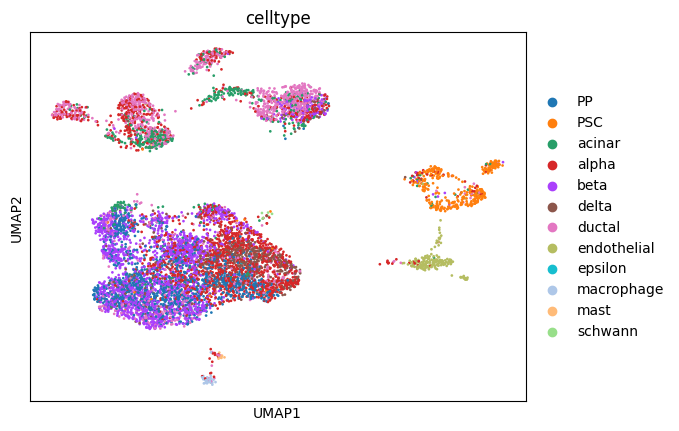

In [112]:
sc.tl.pca(data_adv)
sc.pp.neighbors(data_adv)
sc.tl.umap(data_adv)
sc.pl.umap(data_adv, color='celltype')

In [113]:
eplison = 10

In [114]:
X_tr_noise = X_tr + torch.FloatTensor(np.asarray(eplison * np.random.rand(X_tr.shape[0], X_tr.shape[1])))

In [116]:
with torch.no_grad():
    y_pred = model.encoder(X_tr_noise.cuda())
    _ , y_pred = torch.max(y_pred, 1)

In [118]:
train_label = le.inverse_transform(y_pred.cpu())

In [119]:
sklearn.metrics.classification_report(y_tr, y_pred.cpu())

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

'              precision    recall  f1-score   support\n\n         0.0       0.09      0.15      0.11       274\n         1.0       0.70      0.40      0.51       400\n         2.0       0.44      0.38      0.41       862\n         3.0       0.58      0.61      0.60      2355\n         4.0       0.51      0.53      0.52      2187\n         5.0       0.38      0.19      0.25       602\n         6.0       0.38      0.53      0.44       973\n         7.0       0.79      0.35      0.49       208\n         8.0       0.00      0.00      0.00        14\n         9.0       1.00      0.02      0.05        41\n        10.0       0.00      0.00      0.00        21\n        11.0       0.00      0.00      0.00        10\n        12.0       0.00      0.00      0.00         3\n\n    accuracy                           0.48      7950\n   macro avg       0.37      0.24      0.26      7950\nweighted avg       0.50      0.48      0.48      7950\n'

In [120]:
model

LitAutoEncoder(
  (encoder): Encoder(
    (shared_layers): Sequential(
      (0): Linear(in_features=500, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=512, out_features=13, bias=True)
    )
    (softmax): Softmax(dim=1)
  )
  (loss): CrossEntropyLoss()
)

In [121]:
eplison = 10
np.random.seed(2023)
rand_data = torch.FloatTensor(np.asarray(np.random.rand(X_tr.shape[0], X_tr.shape[1])))

In [122]:
X_tr_noise = X_tr + eplison  *  torch.FloatTensor(np.asarray(np.random.rand(X_tr.shape[0], X_tr.shape[1])))

In [125]:
with torch.no_grad():
    y_pred = model.encoder(X_tr_noise.cuda())
    _ , y_pred = torch.max(y_pred, 1)

In [127]:
train_label = le.inverse_transform(y_pred.cpu())

In [128]:
sklearn.metrics.classification_report(y_tr, y_pred.cpu())

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

'              precision    recall  f1-score   support\n\n         0.0       0.11      0.17      0.14       274\n         1.0       0.67      0.39      0.49       400\n         2.0       0.47      0.40      0.43       862\n         3.0       0.57      0.60      0.59      2355\n         4.0       0.50      0.51      0.51      2187\n         5.0       0.36      0.19      0.25       602\n         6.0       0.35      0.51      0.41       973\n         7.0       0.86      0.32      0.46       208\n         8.0       0.00      0.00      0.00        14\n         9.0       1.00      0.12      0.22        41\n        10.0       1.00      0.05      0.09        21\n        11.0       0.00      0.00      0.00        10\n        12.0       0.00      0.00      0.00         3\n\n    accuracy                           0.47      7950\n   macro avg       0.45      0.25      0.28      7950\nweighted avg       0.49      0.47      0.47      7950\n'

In [129]:
train_label = le.inverse_transform(y_pred.cpu())

sklearn.metrics.classification_report(y_tr, y_pred.cpu())

/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

'              precision    recall  f1-score   support\n\n         0.0       0.11      0.17      0.14       274\n         1.0       0.67      0.39      0.49       400\n         2.0       0.47      0.40      0.43       862\n         3.0       0.57      0.60      0.59      2355\n         4.0       0.50      0.51      0.51      2187\n         5.0       0.36      0.19      0.25       602\n         6.0       0.35      0.51      0.41       973\n         7.0       0.86      0.32      0.46       208\n         8.0       0.00      0.00      0.00        14\n         9.0       1.00      0.12      0.22        41\n        10.0       1.00      0.05      0.09        21\n        11.0       0.00      0.00      0.00        10\n        12.0       0.00      0.00      0.00         3\n\n    accuracy                           0.47      7950\n   macro avg       0.45      0.25      0.28      7950\nweighted avg       0.49      0.47      0.47      7950\n'

In [ ]:
for eps in [0, 0.1, 1, 5,10,15,20,25,30,35,40,45,50]:
    print(eps)
    X_tr_noise = X_tr + eps * rand_data
    with torch.no_grad():
        y_pred = model.encoder(X_tr_noise)
        _ , y_pred = torch.max(y_pred, 1)
    train_label = le.inverse_transform(y_pred.cpu())
    print(sklearn.metrics.classification_report(y_tr, y_pred.cpu()))

In [130]:
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.config import attack_params
from deeprobust.image.utils import download_model
import torch
import deeprobust.image.netmodels.resnet as resnet
from torchvision import transforms,datasets

In [131]:
for eps in [0, 1, 5,10,15,20,25,30,35,40,45,50]:
    print(eps)   
    
    adversary = PGD(model.encoder, 'cuda')

    Adv_img = adversary.generate(X_tr, y_tr, epsilon = eps)

    Adv_img

    with torch.no_grad():
        y_pred = model.encoder(Adv_img)
        _ , y_pred = torch.max(y_pred, 1)

    y_pred

    train_label = le.inverse_transform(y_pred.cpu())

    print(sklearn.metrics.classification_report(y_tr, y_pred.cpu()))

1
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     274.0
         1.0       0.00      0.00      0.00     400.0
         2.0       0.00      0.00      0.00     862.0
         3.0       0.00      0.00      0.00    2355.0
         4.0       0.00      0.00      0.00    2187.0
         5.0       0.00      0.00      0.00     602.0
         6.0       0.00      0.00      0.00     973.0
         7.0       0.00      0.00      0.00     208.0
         8.0       0.00      0.00      0.00      14.0
         9.0       0.00      0.00      0.00      41.0
        10.0       0.00      0.00      0.00      21.0
        11.0       0.00      0.00      0.00      10.0
        12.0       0.00      0.00      0.00       3.0

    accuracy                           0.00    7950.0
   macro avg       0.00      0.00      0.00    7950.0
weighted avg       0.00      0.00      0.00    7950.0



/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [132]:
from deeprobust.image.attack.fgsm import FGSM

In [133]:
for eps in [0, 1, 5,10,15,20,25,30,35,40,45,50]:
    print(eps)   
    
    adversary = FGSM(model.encoder, 'cuda')

    Adv_img = adversary.generate(X_tr, y_tr, epsilon = eps)

    Adv_img

    with torch.no_grad():
        y_pred = model.encoder(Adv_img)
        _ , y_pred = torch.max(y_pred, 1)

    y_pred

    train_label = le.inverse_transform(y_pred.cpu())

    print(sklearn.metrics.classification_report(y_tr, y_pred.cpu()))

1
              precision    recall  f1-score   support

         0.0       0.16      0.42      0.23       274
         1.0       0.87      0.62      0.73       400
         2.0       0.58      0.39      0.46       862
         3.0       0.79      0.74      0.76      2355
         4.0       0.67      0.62      0.64      2187
         5.0       0.63      0.58      0.60       602
         6.0       0.48      0.71      0.57       973
         7.0       0.93      0.66      0.77       208
         8.0       0.00      0.00      0.00        14
         9.0       0.88      0.56      0.69        41
        10.0       0.50      0.14      0.22        21
        11.0       1.00      0.10      0.18        10
        12.0       0.00      0.00      0.00         3

    accuracy                           0.63      7950
   macro avg       0.58      0.43      0.45      7950
weighted avg       0.67      0.63      0.64      7950



/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import math
import copy
import os
import matplotlib.pyplot as plt
from PIL import Image

In [135]:

def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=10):

    f_image = net.forward(image).data.numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()

        for k in range(1, num_classes):
            
            #x.zero_grad()
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [136]:
del model.encoder.shared_layers[1]
del model.encoder.shared_layers[4]

In [137]:
model.encoder

Encoder(
  (shared_layers): Sequential(
    (0): Linear(in_features=500, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=13, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [139]:
pert_sample = []
for i in range(X_train.shape[0]):
    r_tot, loop_i, label, k_i, pert_image = deepfool(X_train[i:i+1,:], model.encoder.cpu())
    pert_sample.append(pert_image.view(-1).numpy())

/tmp/ipykernel_2943175/725753376.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pert_image[None, :],requires_grad=True)
/tmp/ipykernel_2943175/725753376.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pert_image, requires_grad=True)


In [140]:
X_test_pert = torch.FloatTensor(np.array(pert_sample))

In [143]:
X_tr_noise = X_test_pert 
with torch.no_grad():
    y_pred = model.encoder(X_tr_noise)
    _ , y_pred = torch.max(y_pred, 1)
train_label = le.inverse_transform(y_pred.cpu())
print(sklearn.metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.06      0.12       274
         1.0       0.03      0.03      0.03       400
         2.0       0.02      0.01      0.01       862
         3.0       0.03      0.04      0.04      2355
         4.0       0.95      0.17      0.29      2187
         5.0       0.00      0.00      0.00       602
         6.0       0.05      0.03      0.04       973
         7.0       0.04      0.03      0.04       208
         8.0       0.67      0.14      0.24        14
         9.0       0.00      0.00      0.00        41
        10.0       0.00      0.00      0.00        21
        11.0       0.00      0.00      0.00        10
        12.0       0.00      0.00      0.00         3

    accuracy                           0.07      7950
   macro avg       0.21      0.04      0.06      7950
weighted avg       0.32      0.07      0.11      7950



/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/zhao/tl688/conda_envs/deeprobust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi